In [ ]:
import numpy as np
import pandas as pd

In [4]:
labels_df=pd.read_csv("data/labels.csv")
labels_df

,ClassId,Name
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


In [14]:
from PIL import Image
import os

In [11]:
from tqdm import tqdm

x=[]
y=[]
for dirs in os.listdir('E:\\70 Days 70 Project\\Traffic Sign Recognition\\data\\myData'):
    for files in tqdm(os.listdir("E:\\70 Days 70 Project\\Traffic Sign Recognition\\data\\myData\\"+dirs)):
        sign_img = np.array(Image.open("E:\\70 Days 70 Project\\Traffic Sign Recognition\\data\\myData\\"+dirs+"\\"+files).resize((32,32)))
        x.append(sign_img)
        y.append(int(dirs))

100%|██████████| 2790/2790 [00:44<00:00, 62.01it/s] 


In [12]:
from sklearn.utils import shuffle
x_shuffled, y_shuffled = shuffle(x, y)

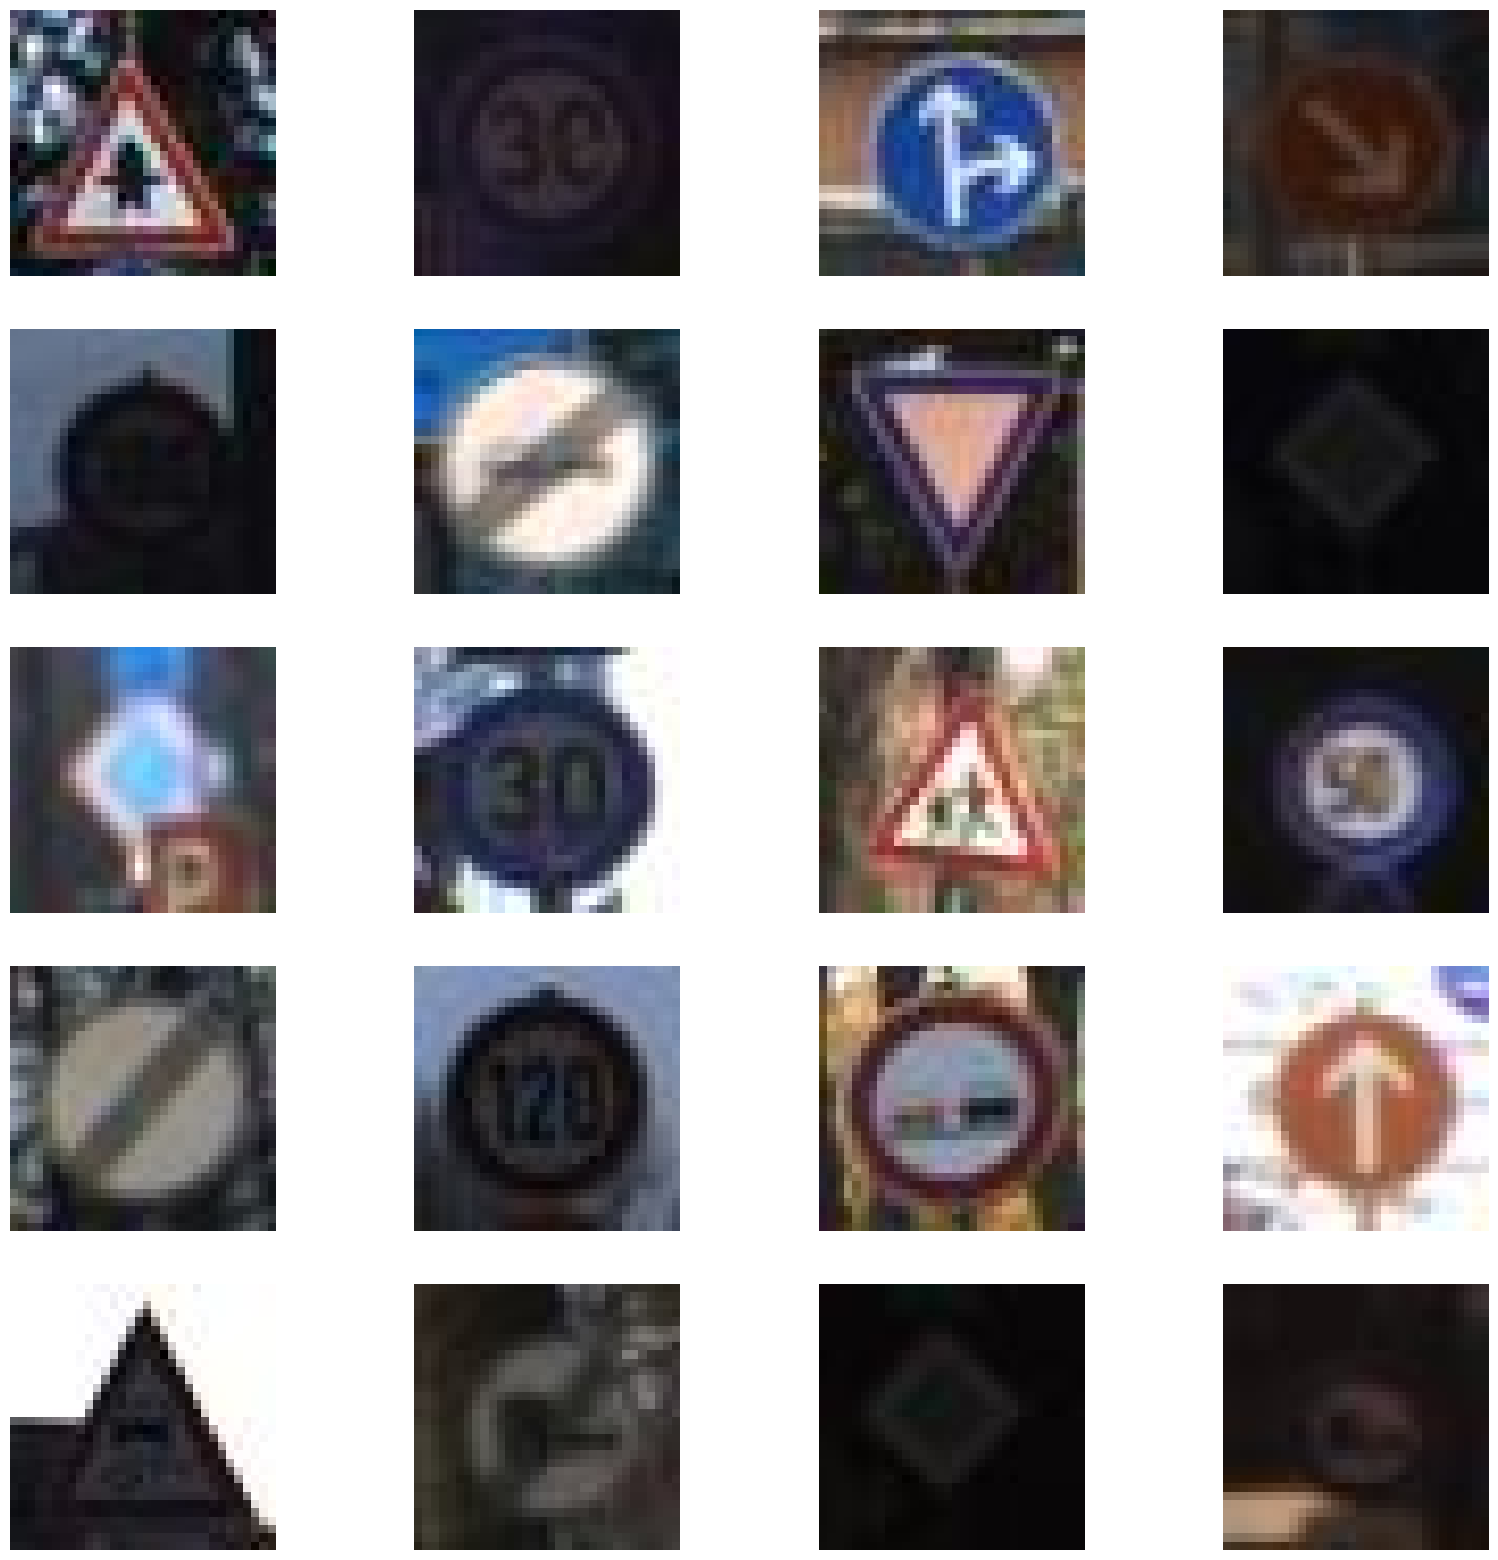

In [13]:
import matplotlib.pyplot as plt

def plot_image(x,y, index):
    image = plt.imshow(x[index])
    ax.grid(False)
    ax.axis('off')    
    return image
fig = plt.figure(figsize=(20, 20))

for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1)
    plot_image(x_shuffled,y_shuffled, i)

plt.show()

In [15]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class TrafficNeuralNet(nn.Module):
    def __init__(self,n_classes):
        super(TrafficNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(64*5*5, 256)
        self.fc2 = nn.Linear(256, n_classes)  # Assuming 43 classes for traffic signs

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64*5*5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

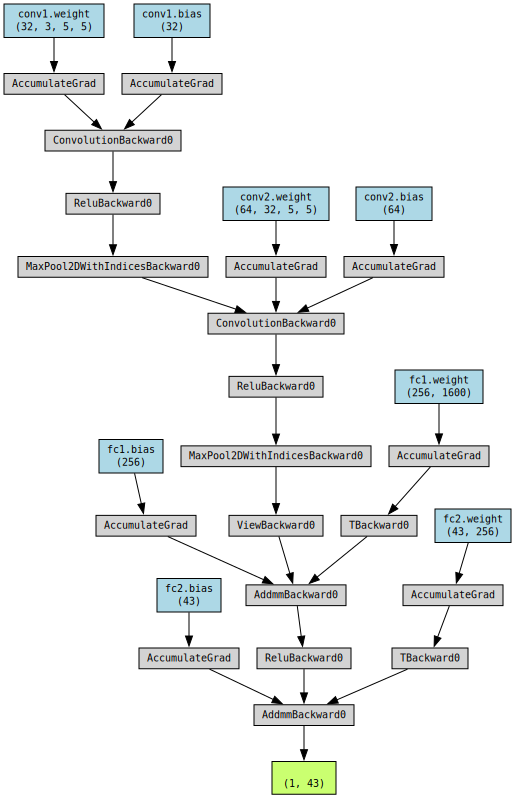

In [ ]:
from torchviz import make_dot
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=TrafficNeuralNet(n_classes=43).to(DEVICE)
make_dot(model(torch.randn(1,3,32,32)), params=dict(model.named_parameters()))

In [27]:
y_shuffled[:10]

[11, 1, 36, 38, 7, 41, 13, 12, 12, 1]

In [33]:
import torch
from torch.utils.data import Dataset, DataLoader

class TrafficSignDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Convert numpy array to torch tensor
        # Convert from uint8 (0-255) to float32 and normalize to [0, 1]
        image = torch.from_numpy(image).float() / 255.0
        
        # Convert from (H, W, C) to (C, H, W) format for PyTorch
        image = image.permute(2, 0, 1)
        
        if self.transform:
            image = self.transform(image)
        
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label
    
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=0.2, random_state=42)
train_dataset = TrafficSignDataset(X_train, y_train)
val_dataset = TrafficSignDataset(X_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [31]:
epochs = 10
batch_size = 32
learning_rate = 0.0003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs):
    model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss/len(val_dataloader)}")
    

Epoch 1/10, Validation Loss: 0.22030024877729049
Epoch 2/10, Validation Loss: 0.09139209134147327
Epoch 3/10, Validation Loss: 0.051106930927224264
Epoch 4/10, Validation Loss: 0.058944603335913004
Epoch 5/10, Validation Loss: 0.04321138559348523
Epoch 6/10, Validation Loss: 0.03430695461532982
Epoch 7/10, Validation Loss: 0.02186846288755058
Epoch 8/10, Validation Loss: 0.03003734161373907
Epoch 9/10, Validation Loss: 0.013486409391545686
Epoch 10/10, Validation Loss: 0.010824123355698295


In [46]:
# Predict on a single image
model.eval()
test_img = x_shuffled[10]
test_img_tensor = torch.from_numpy(test_img).float() / 255.0
test_img_tensor = test_img_tensor.permute(2, 0, 1).unsqueeze(0)

with torch.no_grad():
    outputs = model(test_img_tensor)
    _, predicted_class = torch.max(outputs.data, 1)
    predicted_class = predicted_class.item()  # Convert tensor to integer
    
predicted_label = labels_df[labels_df['ClassId'] == predicted_class]['Name'].values[0]
actual_label = labels_df[labels_df['ClassId'] == y_shuffled[10]]['Name'].values[0]
print(f"Predicted: {predicted_class} - {predicted_label}")
print(f"Actual: {y_shuffled[10]} - {actual_label}")

Predicted: 28 - Children crossing
Actual: 28 - Children crossing


In [38]:
# Evaluate accuracy on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 99.69%
